### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
from scipy import stats
import matplotlib
import csv
import re

## 1.Crawl Gang Li citation information from 2003 to 2021

 <div class="alert alert-block alert-info">

**Code**: <br>
    The code to generate the csv for Gang Li's citation from 2003 to 2021
</div>

In [ ]:
#import pandas as pd
#create_df = pd.DataFrame()
import sys
import pandas as pd
if sys.version_info[0] == 3:
    from urllib.request import urlopen, Request
else:
    from urllib import urlopen, Request
from bs4 import BeautifulSoup

url = 'https://scholar.google.com/citations?user=dqwjm-0AAAAJ#d=gsc_md_hist'
req = Request(url, headers = { 'User-Agent': 'Mozilla/5.0' })

web_byte = urlopen(req).read()
web_page = web_byte.decode('utf-8') # latin-1

soup = BeautifulSoup(web_page, 'lxml')
chart = soup.find('div', class_='gsc_md_hist_b')
html_years = chart.find_all('span', class_="gsc_g_t")
html_citations = chart.find_all('span', class_="gsc_g_al")
years = []
n_citations = []

for html_year in html_years:
  year = html_year.get_text()
  years.append(year)

for html_citation in html_citations:
  citation = html_citation.get_text()
  n_citations.append(citation)

data = {
    "year": years,
    "Citation": n_citations
}
create_df = pd.DataFrame(data)
create_df.to_csv("Citation2003-2021.csv", index=False)
create_df

,year,Citation
0,2003,15
1,2004,34
2,2005,17
3,2006,11
4,2007,33
5,2008,41
6,2009,57
7,2010,68
8,2011,105
9,2012,131


## 2.Train Arima to predict the 2018 to 2020 citation

### 2.1 Train Arima Model
 <div class="alert alert-block alert-info">

**Code**: <br>
    create_df and then perform the
Arima training with parameter of $p=1$, $q=1$ and $d=1$ on data from 2003 to 2017 (15 years)
</div>

In [ ]:
!pip install "statsmodels==0.11.1"

In [ ]:
# create_df to split the data into train (year 2003 to 2017) and test
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA

# Get years
data = "Citation2003-2021.csv"
years = list(years)

# Load dataset and transform to series
series = read_csv(data, header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
size = len(X) - 4
train, test = X[0:size], X[size:(len(X) - 1)]

# fit an ARIMA model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# forecast
result = model_fit.get_forecast()

# summarize forecast
print('Expected: %.3f' % result.predicted_mean)
print('Forecast: %.3f' % test[0])
print('Standard Error: %.3f' % result.se_mean)
print(model_fit.summary())


Expected: 427.300
Forecast: 452.000
Standard Error: 20.043
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -62.512
Date:                Sat, 22 May 2021   AIC                            131.024
Time:                        05:48:06   BIC                            132.941
Sample:                             0   HQIC                           130.846
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9480      0.254      3.737      0.000       0.451       1.445
ma.L1         -0.4727      0.697     -0.678      0.498      -1.839      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


### 2.2 Predicting the citation and Calculate the RMSE
 <div class="alert alert-block alert-info">

**Code**: <br>
    Use the trained Arime model to predict the citation on year 2018, 2019 and 2020.
I also perform the evaluation by comparing the predicted citation from 2018 to 2020 with 
the true citation from 2018 to 2020 and calculate the RMSE (root mean square error).
</div>

In [ ]:
# predict the citation and save it to variable preds. print the output of the confidence interval(95%) here as well
size = len(X) - 4
predictions = []
test = []
train, test = X[0:size], X[size:len(X) - 1]
history = [x for x in train]
predictions = list()
confidence_intervals = []
years_for_prediction = ["2018", "2019", "2020"]

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.get_forecast()
    yhat = output.predicted_mean
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print("* %s" % (years_for_prediction[t]))
    print('predicted=%f, expected=%f' % (yhat, obs))
    ci = output.conf_int(0.05)
    confidence_intervals.append(ci[0])
    print('95%% Interval: %.3f to %.3f\n' % (ci[0,0], ci[0,1]))


* 2018
predicted=427.299935, expected=452.000000
95% Interval: 388.016 to 466.584

* 2019
predicted=505.181945, expected=583.000000
95% Interval: 465.751 to 544.613

* 2020
predicted=682.932554, expected=842.000000
95% Interval: 629.859 to 736.006



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [ ]:
# Print the error below by comparing the test and preds:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

# show the performance RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print ('Test RMSE: %.3f' % rmse)

Test RMSE: 103.228


### 2.3 Draw the visualization to compare

 <div class="alert alert-block alert-info">

**Code**: <br>
   Use matplotlib to draw the line plot with training data from 2013 to 2017,
the testing truth, the prediction and also the confidence interval (95%). 
</div>

[]

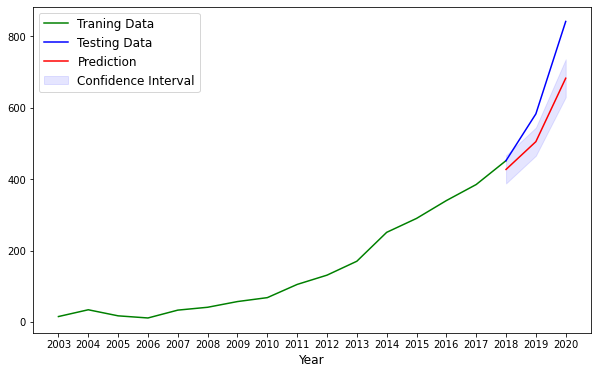

In [ ]:
# Visualize as required, the prediction with its confidence interval
from matplotlib import pyplot as plt
import matplotlib.ticker
# x-axis
training_data_years = years[0:size+1]
testing_data_years = years[size:(len(X) - 1)]
x = len(training_data_years) + len(testing_data_years) - 1
x_range = list(range(x))
training_data_x_range = x_range[0:len(training_data_years)]
testing_data_x_range = x_range[len(training_data_years)-1:]

# y-axis
train_y_data = X[0:size+1]
test_y_data = list(test)

# Plot
fig, ax = plt.subplots(figsize=(10,6))


ax.plot(training_data_x_range, train_y_data, color="green", label="Traning Data")
ax.plot(testing_data_x_range, test_y_data, color="blue", label="Testing Data")
ax.plot(testing_data_x_range, predictions, color="red", label="Prediction")
ax.fill_between(testing_data_x_range,
                np.array(confidence_intervals)[:,0], np.array(confidence_intervals)[:,1],
                alpha=0.1, color='b', label="Confidence Interval")

# Customization
ax.legend(fontsize=12)
ax.set_xlabel("Year", size="12")
ax.set_xticks(np.arange(0, len(x_range)+1, 1))
ax.set_xticklabels(years[:-1], {"fontsize": 10})
plt.plot()

## 3.Conduct the Grid Search with paramter selection and then predict the 2021 and 2022

### 7.1 Grid Search
 <div class="alert alert-block alert-info">

**Code**: 
 Run the grid search for parameter $p=[1,2]$, 
$q=[1,2]$,
$d=[1,2]$
with training data on year 2003 to 2017 and testing data on 2018 to 2020
The result of the search on each paratemer combination (eg: p=1,q=1,d=1)
will need to be stored in the "search-results.csv",
The search-results.csv will have the column of "RMSE" and column "PARAMETER".
</div>

In [ ]:
#p = list(range(1,3))
#q = list(range(1,3))
#d = list(range(1,3))
#RMSE = []
#PARAMETER = []
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load dataset and transform to series
data = "Citation2003-2021.csv"
series = read_csv(data, header=0, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
size = len(X) - 4
train, test = X[0:size], X[size:(len(X) - 1)]
history = [x for x in train]
p = list(range(1,3))
q = list(range(1,3))
d = list(range(1,3))
predictions = list()
RMSE = []
PARAMETER = []

# walk-forward validation
min_rmse = float('inf')
chosen_paramters = []

for i1 in p:
  for i2 in d:
    for i3 in q:
      print('* p=%s, d=%s, q=%s' % (i1, i2, i3))
      PARAMETER.append('p=%s d=%s q=%s' % (i1, i2, i3))
      for t in range(len(test)):
        model = ARIMA(history, order=(i1, i2, i3))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
      
      rmse = sqrt(mean_squared_error(test, predictions))
      if rmse <= min_rmse: 
        min_rmse = rmse
        chosen_paramters = [i1, i2, i3]

      history = [x for x in train]
      predictions = list()
      RMSE.append(rmse)
      print('Test RMSE: %.3f\n' % rmse)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


* p=1, d=1, q=1
predicted=427.299935, expected=452.000000
predicted=505.181945, expected=583.000000
predicted=682.932554, expected=842.000000
Test RMSE: 103.228

* p=1, d=1, q=2
predicted=426.674396, expected=452.000000
predicted=496.610744, expected=583.000000
predicted=686.570258, expected=842.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 103.703

* p=1, d=2, q=1
predicted=432.527310, expected=452.000000
predicted=506.746386, expected=583.000000
predicted=692.309049, expected=842.000000
Test RMSE: 97.641

* p=1, d=2, q=2
predicted=441.377019, expected=452.000000
predicted=520.599055, expected=583.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=691.282967, expected=842.000000
Test RMSE: 94.379

* p=2, d=1, q=1
predicted=427.740894, expected=452.000000
predicted=502.910867, expected=583.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=704.464130, expected=842.000000
Test RMSE: 92.950

* p=2, d=1, q=2
predicted=436.471959, expected=452.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=501.116477, expected=583.000000
predicted=684.975820, expected=842.000000
Test RMSE: 102.636

* p=2, d=2, q=1
predicted=415.757531, expected=452.000000
predicted=506.543661, expected=583.000000
predicted=678.621317, expected=842.000000
Test RMSE: 106.226

* p=2, d=2, q=2
predicted=421.449300, expected=452.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=509.110962, expected=583.000000
predicted=680.043916, expected=842.000000
Test RMSE: 104.280



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
# Generate the seach-results.csv and print the top 6 rows
#Results = pd.DataFrame({'RMSE':RMSE,'Parameter':PARAMETER})
#Results.head(6)
Results = pd.DataFrame({'RMSE': RMSE,'Parameter': PARAMETER})
Results.to_csv("seach-results.csv", index=False)
print(Results)
Results.head(6)

         RMSE    Parameter
0  103.228218  p=1 d=1 q=1
1  103.702932  p=1 d=1 q=2
2   97.640804  p=1 d=2 q=1
3   94.379288  p=1 d=2 q=2
4   92.949608  p=2 d=1 q=1
5  102.636291  p=2 d=1 q=2
6  106.225676  p=2 d=2 q=1
7  104.279605  p=2 d=2 q=2


,RMSE,Parameter
0,103.228218,p=1 d=1 q=1
1,103.702932,p=1 d=1 q=2
2,97.640804,p=1 d=2 q=1
3,94.379288,p=1 d=2 q=2
4,92.949608,p=2 d=1 q=1
5,102.636291,p=2 d=1 q=2


### 3.2 TRAIN With Best Parameter Set with data up to 2020 and Predict the 2021 and 2022

<div class="alert alert-block alert-info">

**Code**: <br>
  Perform the training with Arima on data from 2003 to 2020 with best parameter that have found,
and then conduct the prediction for year 2021 and 2022.
</div>

In [ ]:
#train = create_df.citation_all.values[:-1]
import numpy as np

data = "Citation2003-2021.csv"
series = read_csv(data, header=0, index_col=0, parse_dates=True, squeeze=True)


# predict for 2021 and 2022
X = series.values
X = X.astype('float32')
size = len(X) - 1
train = X[0:size]
best_parameter = chosen_paramters
years_for_predictions = ["2021", "2022"]

model = ARIMA(train, order=(best_parameter[0],best_parameter[1],best_parameter[2]))
model_fit = model.fit()
output = model_fit.get_forecast(2)
confidence_intervals = output.conf_int(0.05)
predictions = output.predicted_mean

for i in range(len(predictions)):
  yhat = predictions[i]
  ci = confidence_intervals[i]
  print('* %s' % (years_for_predictions[i]))
  print('predicted=%.3f' % (yhat))
  print('95%% Interval: %.3f to %.3f' % (ci[0], ci[1]))




* 2021
predicted=1151.503
95% Interval: 1075.843 to 1227.163
* 2022
predicted=1477.645
95% Interval: 1280.076 to 1675.213


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<div class="alert alert-block alert-info">

**Code**: <br>
  I use matplotlib to draw the line plot with training data from 2013 to 2020, the prediction and also the confidence interval (95%).

</div>

[]

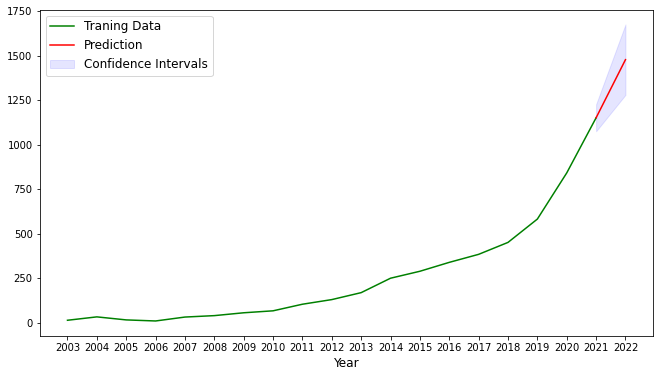

In [ ]:
# Plot the points and the prediction with its confidence interval
from matplotlib import pyplot as plt
import matplotlib.ticker
import numpy as np
# x-axis
size = len(X)
training_data_years = years[0:size]
predicted_data_years = years[size-1:] + ['2022']
x = len(training_data_years) + len(predicted_data_years) - 1
x_range = list(range(x))
training_data_x_range = x_range[0:len(training_data_years)]
predicted_data_x_range = x_range[len(training_data_years)-1:]


# y-axis
predicted_y_data = [prediction for prediction in predictions]

train_y_data = list(X[0:size-1])
train_y_data.append(predicted_y_data[0])

# Plot
fig, ax = plt.subplots(figsize=(11,6))


ax.plot(training_data_x_range, train_y_data, color="green", label="Traning Data")
ax.plot(predicted_data_x_range, predicted_y_data, color="red", label="Prediction")
ax.fill_between(predicted_data_x_range,
                np.array(confidence_intervals)[:,0], np.array(confidence_intervals)[:,1],
                alpha=0.1, color='b', label="Confidence Intervals")

# Customization
xticks_labels = [year for year in years]
xticks_labels.append('2022')
ax.legend(fontsize=12)
ax.set_xlabel("Year", size="12")
ax.set_xticks(np.arange(0, len(x_range)+1, 1))
ax.set_xticklabels(xticks_labels, {"fontsize": 10})
plt.plot()



### Analysis
RMSE indicates the fit of actual data and the prediction model. The lower RMSE, the better the model. In this case, the lowest RMSE = 92.949608, therefore, the best parameter is p= 2, d= 1, q=1 (based on data crawling from https://scholar.google.com/citations?user=dqwjm-0AAAAJ on 3:50pm 22 May 2021).
Base on the data from 2003 to 2020, the model predicted the number of citations will grow dramatically with 1151 citations in 2021 and 1477 citations in 2022. With 95% of confidence, the true value of the number of citations lies somewhere between 1075 and 1227 citations in 2021, and between 1280 and 1675 citations in 2022.